# Installs

In [ ]:
# %pip install tensorflow
# %pip install keras
# %pip install tqdm
# %pip install lightgbm

# Imports



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.svm import LinearSVR as SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from lightgbm import LGBMRegressor as LGB
from sklearn.multioutput import RegressorChain as RC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler as MM
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import r2_score as r2_s
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/swara-p/datasets/main/bitcoin_data/bitcoin.csv",thousands=',')

In [ ]:
df.head(2)

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000",45535800000
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000",44890700000


# Preprocessing and Visualization

In [ ]:
df.dtypes

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume         object
Market Cap      int64
dtype: object

In [ ]:
# setting the date column as index

df.index = pd.to_datetime(df['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y")))
df.drop(['Date'],axis=1,inplace=True)

In [ ]:
# Sorted the dataframe in order of increasing dates so as to split the data into train and test where last part of the df would serve as test (future prediction)

df = df.sort_index()

In [ ]:
# Volume column has nan values disguised as "-", hence replacing them with nan
# And for converting datatype of volume column to int, replacing the commas with space and then did datatype conversion

df = df.replace({"-":np.nan})
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

In [ ]:
# Checking the number of null values

df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume        243
Market Cap      0
dtype: int64

In [ ]:
# Checking the length of dataframe to get an idea of what should be done with null values

df.shape

(1556, 6)

In [ ]:
# Since 15% values are null, so dropping the rows would result in loss of information
# Hence, interpolating the null values using 'forward' method

df = df.interpolate(method ='linear', limit_direction ='forward')
df.isnull().sum().sum()

243

In [ ]:
# Created a column Difference which depicted the difference between Hight and Low columns

df['Difference'] = df['High'] - df['Low']

In [ ]:
df.head(2)

,Open,High,Low,Close,Volume,Market Cap,Difference
Date,,,,,,,
2013-04-28,135.30,135.98,132.1,134.21,NaN,1500520000,3.88
2013-04-29,134.44,147.49,134.0,144.54,NaN,1491160000,13.49


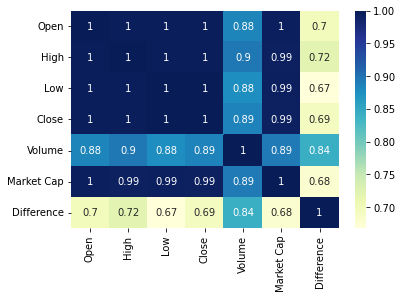

In [ ]:
# Visualizing the correlation among the different columns woth help of a heatmap

sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

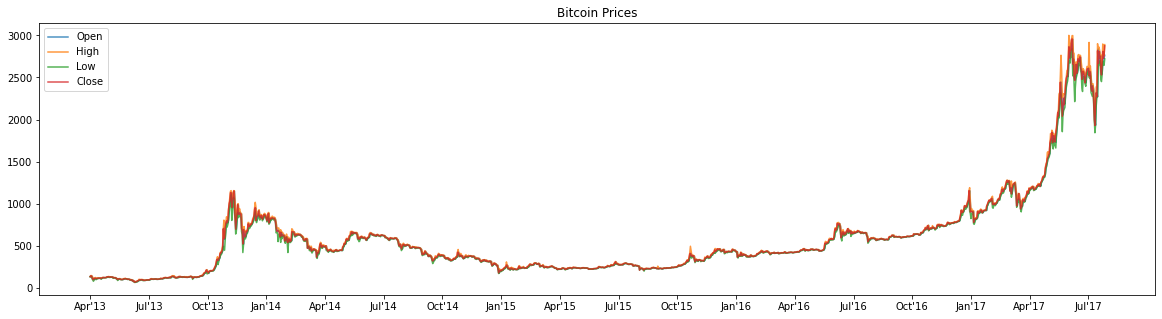

In [ ]:
plt.figure(figsize=(20,5))
for i in df.columns[:4]:
  plt.plot(np.arange(df.shape[0]),df[i],label=f'{i}',alpha=0.8)
plt.title("Bitcoin Prices")
plt.xticks(np.arange(0,df.shape[0],90),[df.index[i].strftime("%b'%y") for i in range(df.shape[0]) if i%90==0])
plt.legend()
plt.show()

In [ ]:
# function that creates a dataframe consisting of only Close columns, according to the day whose Close price is to be predicted and 
# number of previous days whose data is to be used for that prediction

def transform_df(df,days_to_predict,look_back,keep_cols=None,window_size=1):
    df_new = pd.DataFrame()
    for i in range(look_back):
        df_new[f'Close_t+{i}'] = df['Close'].shift(-i)
        if keep_cols!=None:
            for j in keep_cols:
                df_new[f'{j}+{i}'] = df[{j}].shift(-i)
    for i in range(window_size):
        df_new[f'Prediction_t+{i+days_to_predict}'] = df['Close'].shift(-i-days_to_predict)
    df_new.dropna(inplace=True)
    return df_new

In [ ]:
# function that splits a datframe into train and test sets

def get_X_y_tts(df,split_ratio=0.7):
  i = 0
  for j in range(len(df.columns)):
    if df.columns[j].startswith('P'):
      i=j
      break
  
  X = df.iloc[:,:i]
  y = df.iloc[:,i:]
  tts = round(len(X)*split_ratio)
  X_train = X.iloc[:tts,:]
  X_test = X.iloc[tts:,:]
  y_train = y.iloc[:tts]
  y_test = y.iloc[tts:]
  return X_train,X_test,y_train,y_test

In [ ]:
# function to normalize the data

def get_scaled(train,test):
  ss = SS()
  train = ss.fit_transform(train)
  test = ss.transform(test)
  return train,test

# Training and Visualizing results

In [ ]:
# initializing a list of models which are to be trained and list of metrics for evaluation

models = [LR(),KNR(),MLP(),SVR(),RFR(),LGB()]
model_names = ["LinearRegression", "KNearestNeighbour", "MultilayerPerceptron", "SupportVectorRegression", "RandomForestRegressor", "LightGBMRegressor"]
metrics_short_names = ['mse','mae','r2']
metrics_arr = ['Mean_Absolute_Error','Mean_Squared_Error','R2_Score']
model_short_names = ['LinReg', 'KNN', 'MLP', 'SVM', 'RF', 'LGBM']

In [ ]:
# this function trains different models and stores the model, predicted values, errors and r2score for each of them in dictionary

def get_performance(X_train,y_train,X_test,y_test):
  performance = {}
  for i in tqdm(range(len(models)),desc='models'):
    d = {}
    m = models[i]
    if(y_test.shape[1]!=1):
      m = RC(m)
    m = m.fit(X_train,y_train)
    yptr = m.predict(X_train)
    ypts = m.predict(X_test)
    d["model"] = m
    d["yptr"] = yptr
    d["ypts"] = ypts
    d["tr_scores"] = {"mse":mse(y_train,yptr),"mae":mae(y_train,yptr),"r2":r2_s(y_train,yptr)}
    d["ts_scores"] = {"mse":mse(y_test,ypts),"mae":mae(y_test,ypts),"r2":r2_s(y_test,ypts)}
    performance[f"{model_names[i]}"]=d
  return performance

# prints mean_absolute_error, mean_squared_error and r2_score 

def print_metrics(performance):
  for i in performance.keys():
    print(f"{i}:")
    print(f"Train scores:{performance[i]['tr_scores']}")
    print(f"Test scores:{performance[i]['ts_scores']}")
    print()

# plots the y_train vs y_predicted and y_test vs y_predicted

def plot_pred(performance,y_train,y_test):
  train_len = len(y_train)
  test_len = len(y_test)
  for i in performance.keys():
    if(y_train.shape[1]==1):

      fig, axs = plt.subplots(1, 2,figsize=(24,4))
      axs[0].plot(np.arange(train_len),y_train,label='Actual')
      axs[0].plot(np.arange(train_len),performance[i]['yptr'],label='Predicted',alpha=0.8)
      axs[0].set_title(f"y_train")
      axs[0].legend()
      
      axs[1].plot(np.arange(test_len),y_test,label='Actual')
      axs[1].plot(np.arange(test_len),performance[i]['ypts'],label='Predicted',alpha=0.8)
      axs[1].set_title(f"y_test")
      axs[1].legend()
      plt.suptitle(f"{i}")
      plt.show()

    else:

      fig, axs = plt.subplots(2, y_train.shape[1],figsize=(24,8))
      for j in range(y_train.shape[1]):
          axs[0][j].plot(np.arange(train_len),y_train_scaled2[:,j],label='Actual')
          axs[0][j].plot(np.arange(train_len),performance2[i]['yptr'][:,j],label='Predicted',alpha=0.8)
          axs[0][j].set_title(f"y_train[{j}]")
          axs[0][j].legend()
          
          axs[1][j].plot(np.arange(test_len),y_test_scaled2[:,j],label='Actual')
          axs[1][j].plot(np.arange(test_len),performance2[i]['ypts'][:,j],label='Predicted',alpha=0.8)
          axs[1][j].set_title(f"y_test[{j}]")
          axs[1][j].legend()
      plt.suptitle(f"{i}")
      plt.show()

# comparing the erros and r2_score of different models applied

def compare_models(performance):
  fig, axs = plt.subplots(1, 3,figsize=(24,5))
  for i in range(3):
      axs[i].plot(np.arange(len(models)),[performance[j]["tr_scores"][metrics_short_names[i]] for j in performance.keys()],label='Train',marker='o')
      axs[i].plot(np.arange(len(models)),[performance[j]["ts_scores"][metrics_short_names[i]] for j in performance.keys()],label='Test',marker='o')
      axs[i].set_xticks(np.arange(len(models)))
      axs[i].set_xticklabels(model_short_names)
      axs[i].set_title(f"{metrics_arr[i]}")
      axs[i].legend()
  plt.show()

## Transformation 1

> Creating a dataframe where Close price of 5 days is given as input and close price of 6th day is to be predicted



In [ ]:
df1 = transform_df(df,5,5)
X_train1, X_test1, y_train1, y_test1 = get_X_y_tts(df1,0.7)
X_train_scaled1, X_test_scaled1 = get_scaled(X_train1,X_test1)
y_train_scaled1, y_test_scaled1 = get_scaled(y_train1.values.reshape(-1,1),y_test1.values.reshape(-1,1))

In [ ]:
X_train1.head(2)

,Close_t+0,Close_t+1,Close_t+2,Close_t+3,Close_t+4
Date,,,,,
2013-04-28,134.21,144.54,139.00,116.99,105.21
2013-04-29,144.54,139.00,116.99,105.21,97.75


In [ ]:
y_train1.head(2)

,Prediction_t+5
Date,
2013-04-28,97.75
2013-04-29,112.50


In [ ]:
performance1 = get_performance(X_train_scaled1,y_train_scaled1,X_test_scaled1,y_test_scaled1)

models: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


In [ ]:
print_metrics(performance1)

LinearRegression:
Train scores:{'mse': 0.013878295782546344, 'mae': 0.055609629642199766, 'r2': 0.9861217042174537}
Test scores:{'mse': 0.0875926717137934, 'mae': 0.156311960656031, 'r2': 0.9924794853499119}

KNearestNeighbour:
Train scores:{'mse': 0.012784286719829039, 'mae': 0.05592504671639858, 'r2': 0.987215713280171}
Test scores:{'mse': 9.541938490524398, 'mae': 1.5249559290610373, 'r2': 0.18075009239697049}

MultilayerPerceptron:
Train scores:{'mse': 0.01636610568159011, 'mae': 0.06319698677812725, 'r2': 0.9836338943184099}
Test scores:{'mse': 0.23125643641295243, 'mae': 0.26293380440622366, 'r2': 0.980144829653633}

SupportVectorRegression:
Train scores:{'mse': 0.014210848633757291, 'mae': 0.05487739245774996, 'r2': 0.9857891513662427}
Test scores:{'mse': 0.08219190016053962, 'mae': 0.14641833246705843, 'r2': 0.9929431837483434}

RandomForestRegressor:
Train scores:{'mse': 0.002648186824591972, 'mae': 0.024291443000564204, 'r2': 0.997351813175408}
Test scores:{'mse': 10.34898434

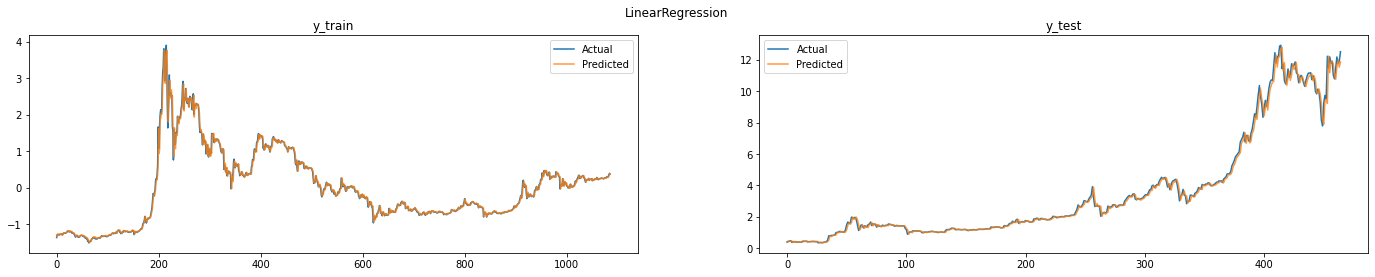

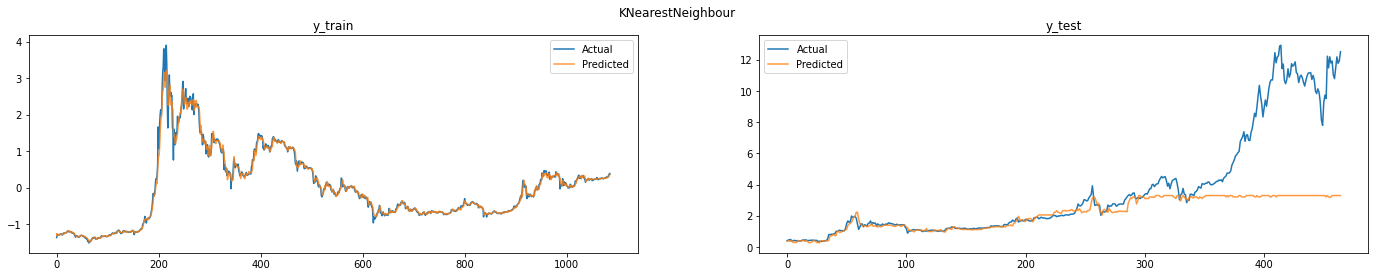

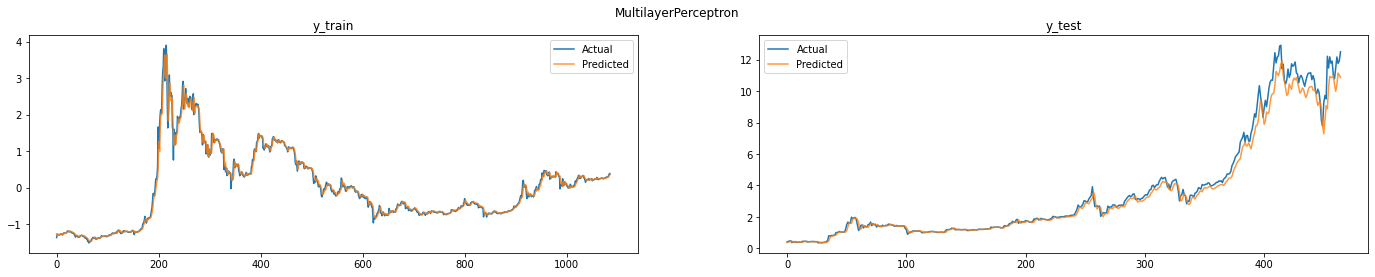

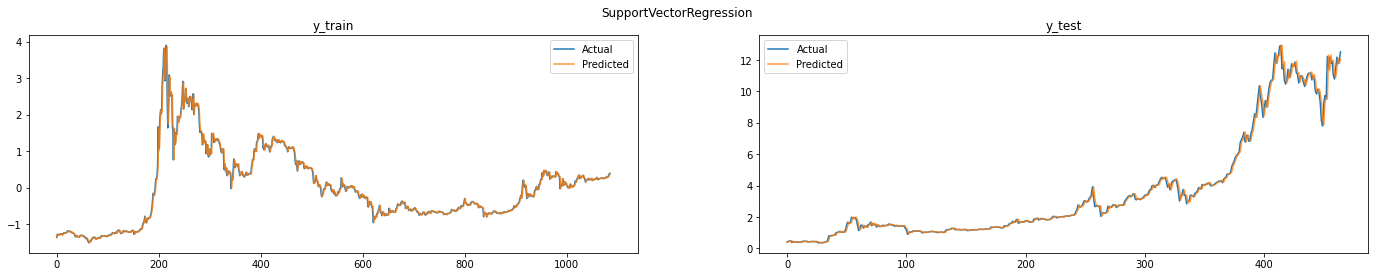

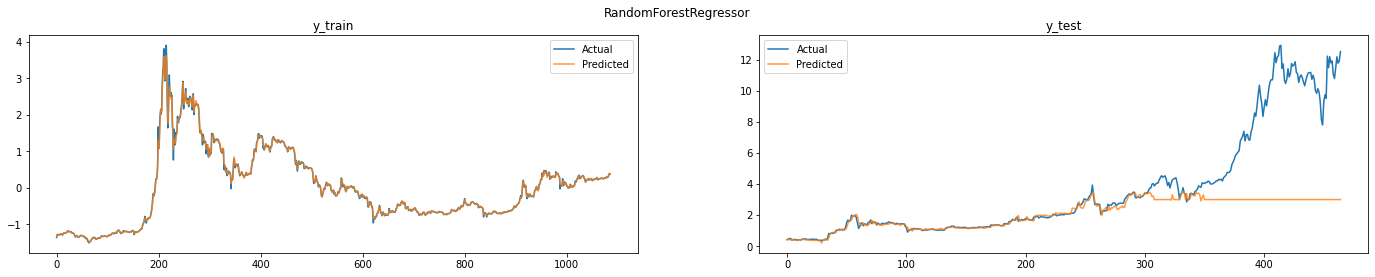

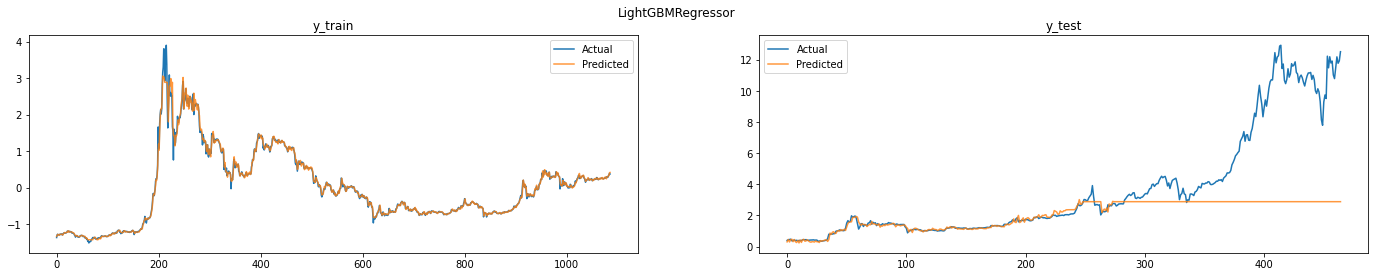

In [ ]:
plot_pred(performance1,y_train_scaled1,y_test_scaled1)

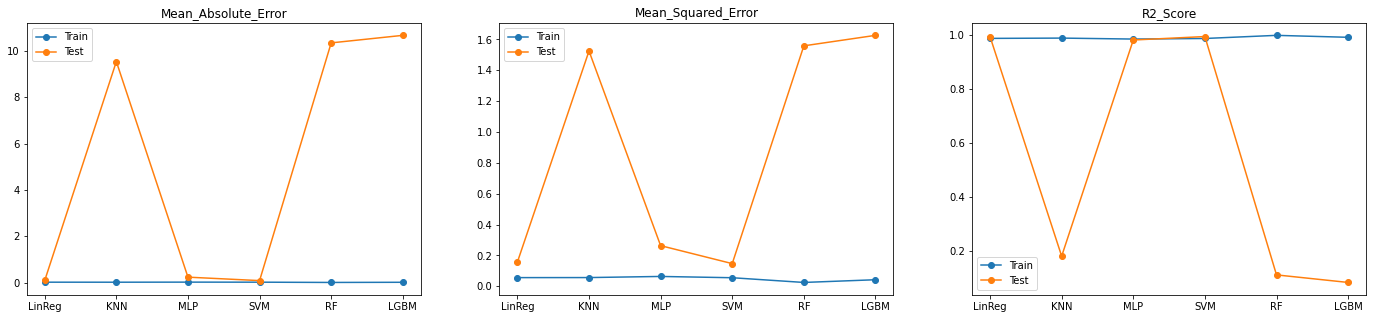

In [ ]:
compare_models(performance1)

## Transformation 2

> Created a dataframe where window size of 5 indicates seeing the value of 25 previous days, predict the closing price of next 5 days

In [ ]:
df2 = transform_df(df,25, 25,window_size=5)
X_train2, X_test2, y_train2, y_test2 = get_X_y_tts(df2,0.7)
X_train_scaled2, X_test_scaled2 = get_scaled(X_train2,X_test2)
y_train_scaled2, y_test_scaled2 = get_scaled(y_train2,y_test2)

In [ ]:
X_train2.head(2)

,Close_t+0,Close_t+1,Close_t+2,Close_t+3,Close_t+4,Close_t+5,Close_t+6,Close_t+7,Close_t+8,Close_t+9,...,Close_t+15,Close_t+16,Close_t+17,Close_t+18,Close_t+19,Close_t+20,Close_t+21,Close_t+22,Close_t+23,Close_t+24
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,134.21,144.54,139.00,116.99,105.21,97.75,112.50,115.91,112.3,111.50,...,117.98,111.50,114.22,118.76,123.02,123.50,121.99,122.00,122.88,123.89
2013-04-29,144.54,139.00,116.99,105.21,97.75,112.50,115.91,112.30,111.5,113.57,...,111.50,114.22,118.76,123.02,123.50,121.99,122.00,122.88,123.89,126.70


In [ ]:
y_train2.head(2)

,Prediction_t+25,Prediction_t+26,Prediction_t+27,Prediction_t+28,Prediction_t+29
Date,,,,,
2013-04-28,126.7,133.20,131.98,133.48,129.75
2013-04-29,133.2,131.98,133.48,129.75,129.00


In [ ]:
performance2 = get_performance(X_train_scaled2,y_train_scaled2,X_test_scaled2,y_test_scaled2)

models: 100%|██████████| 6/6 [00:28<00:00,  4.80s/it]


In [ ]:
print_metrics(performance2)

LinearRegression:
Train scores:{'mse': 0.03266551105295405, 'mae': 0.10008880743068933, 'r2': 0.9673344889470459}
Test scores:{'mse': 0.31475530018355313, 'mae': 0.30273772315161035, 'r2': 0.973079891375004}

KNearestNeighbour:
Train scores:{'mse': 0.01124001723845022, 'mae': 0.05204575900392119, 'r2': 0.9887599827615497}
Test scores:{'mse': 15.870504352161712, 'mae': 2.2596713943171336, 'r2': -0.36818585548572397}

MultilayerPerceptron:
Train scores:{'mse': 0.02107460219824281, 'mae': 0.09166547951099362, 'r2': 0.9789253978017574}
Test scores:{'mse': 0.47648887346711355, 'mae': 0.3818521590890751, 'r2': 0.9592412457936945}

SupportVectorRegression:
Train scores:{'mse': 0.03610348211697897, 'mae': 0.09795033017396972, 'r2': 0.963896517883021}
Test scores:{'mse': 0.2858926469629143, 'mae': 0.2789040063793302, 'r2': 0.9755521787242826}

RandomForestRegressor:
Train scores:{'mse': 0.010118799791019798, 'mae': 0.04384229475066066, 'r2': 0.9898812002089802}
Test scores:{'mse': 12.8231004316

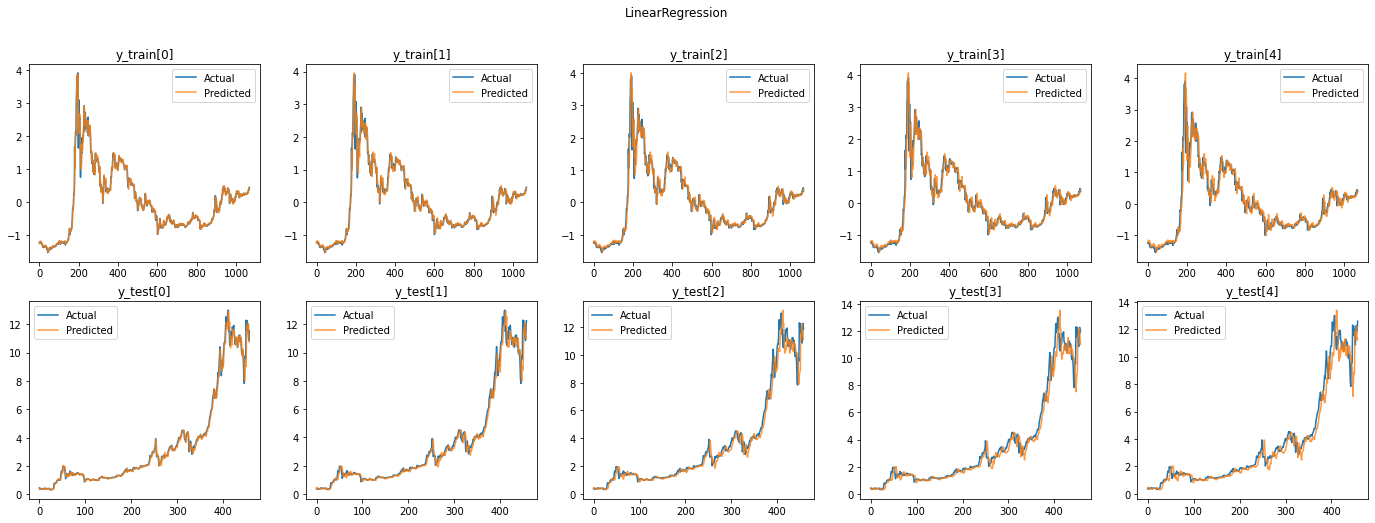

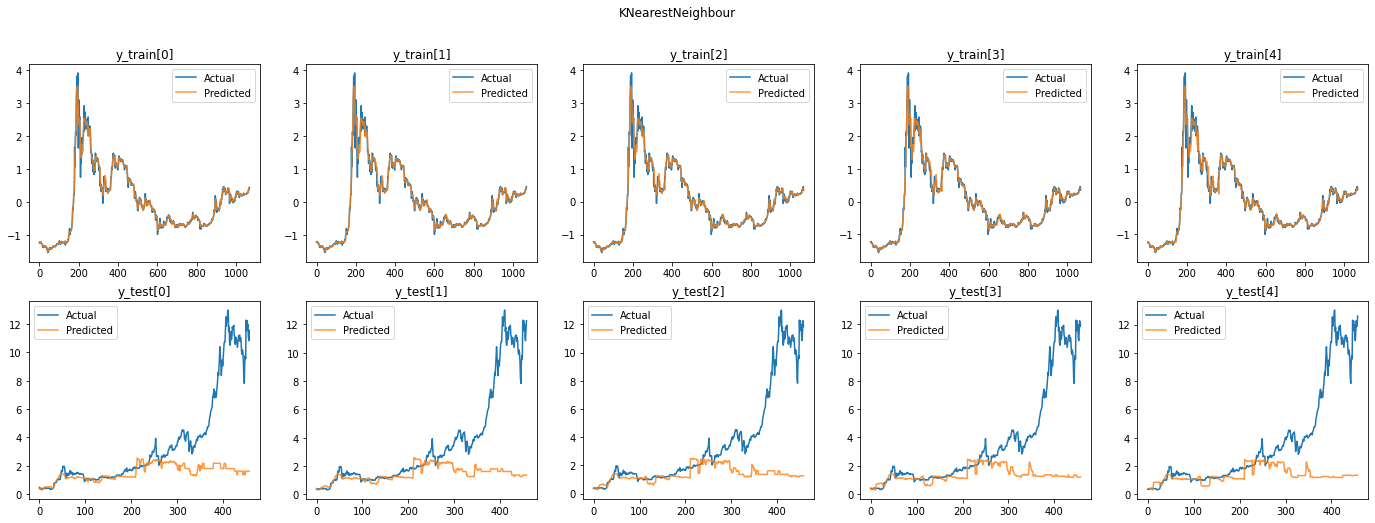

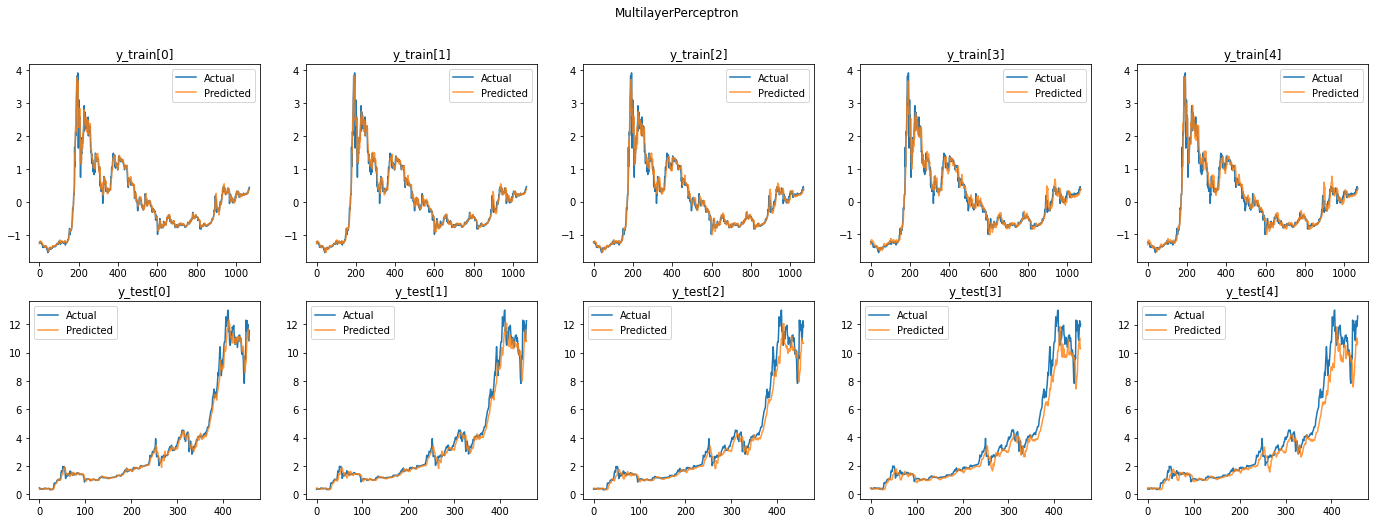

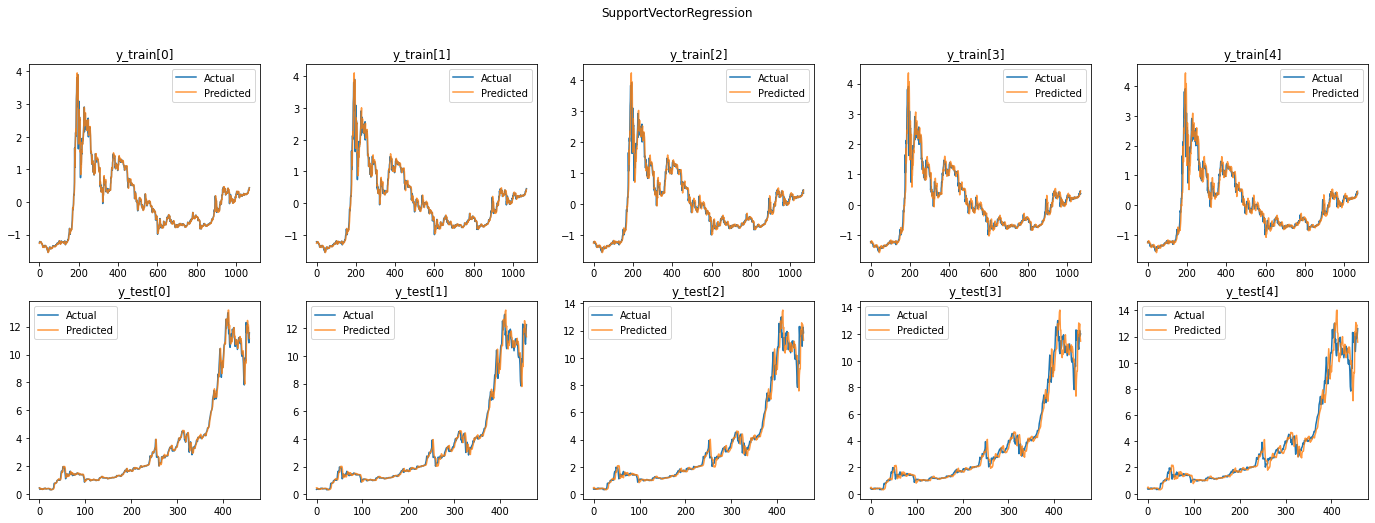

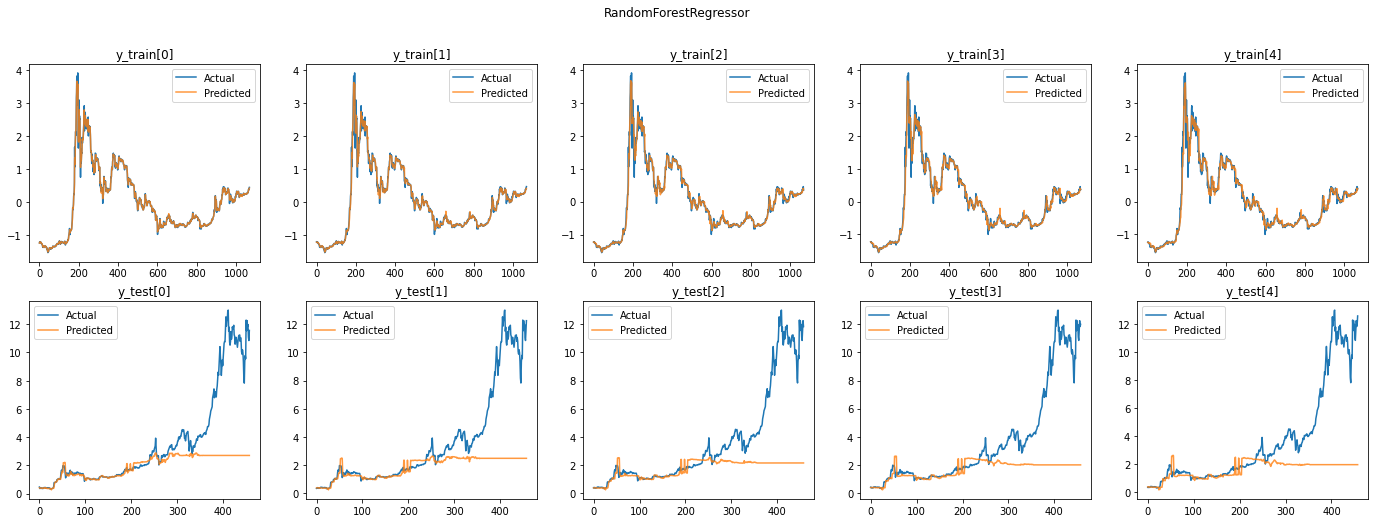

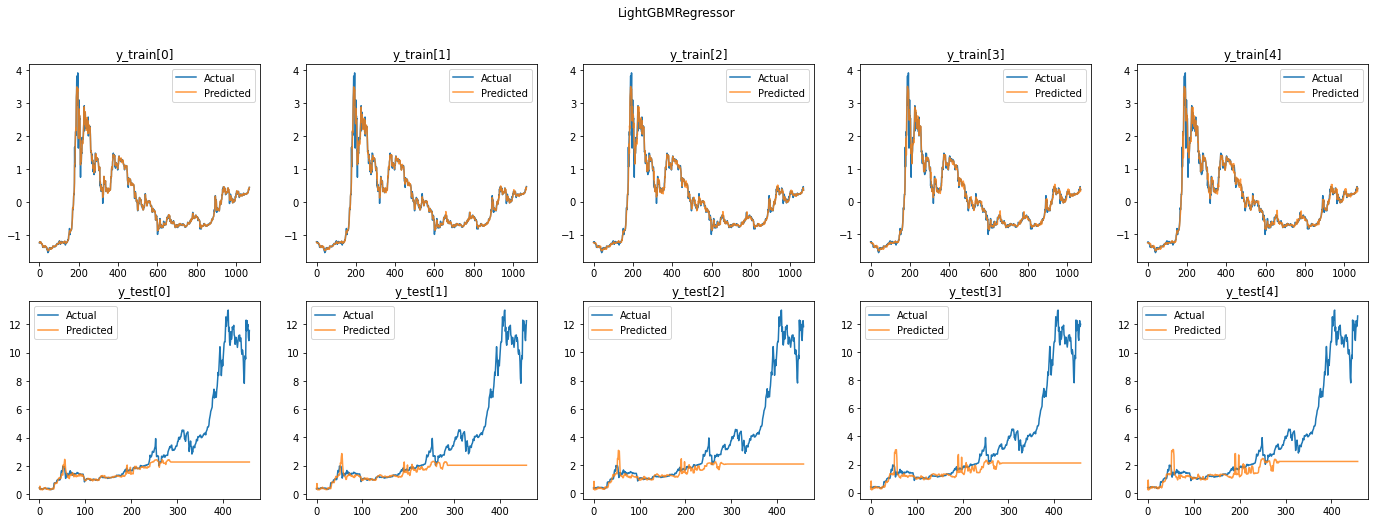

In [ ]:
plot_pred(performance2,y_train_scaled2,y_test_scaled2)

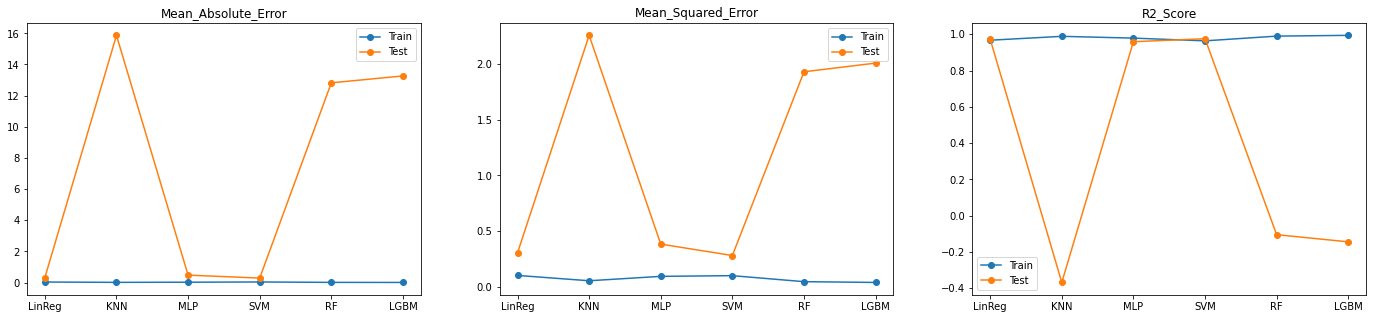

In [ ]:
compare_models(performance2)

## Transformation 3

> Creating a dataframe where Close price of 5 days along with Difference (High - Low) is given as input and Close price of 6th day is to be predicted

In [ ]:
df3 = transform_df(df,5,5,['Difference'])
X_train3, X_test3, y_train3, y_test3 = get_X_y_tts(df3,0.7)
X_train_scaled3, X_test_scaled3 = get_scaled(X_train3,X_test3)
y_train_scaled3, y_test_scaled3 = get_scaled(y_train3.values.reshape(-1,1),y_test3.values.reshape(-1,1))

In [ ]:
X_train3.head(2)

,Close_t+0,Difference+0,Close_t+1,Difference+1,Close_t+2,Difference+2,Close_t+3,Difference+3,Close_t+4,Difference+4
Date,,,,,,,,,,
2013-04-28,134.21,3.88,144.54,13.49,139.00,12.88,116.99,32.17,105.21,33.32
2013-04-29,144.54,13.49,139.00,12.88,116.99,32.17,105.21,33.32,97.75,29.03


In [ ]:
y_train3.head(2)

,Prediction_t+5
Date,
2013-04-28,97.75
2013-04-29,112.50


In [ ]:
performance3 = get_performance(X_train_scaled3,y_train_scaled3,X_test_scaled3,y_test_scaled3)

models: 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


In [ ]:
print_metrics(performance3)

LinearRegression:
Train scores:{'mse': 0.012881875148182967, 'mae': 0.056035451120207296, 'r2': 0.987118124851817}
Test scores:{'mse': 0.09680787411012311, 'mae': 0.17282915459978646, 'r2': 0.9916882882866283}

KNearestNeighbour:
Train scores:{'mse': 0.024519420178760406, 'mae': 0.07879110433337627, 'r2': 0.9754805798212396}
Test scores:{'mse': 10.822207187575357, 'mae': 1.7776511140296998, 'r2': 0.07082903046520284}

MultilayerPerceptron:
Train scores:{'mse': 0.011070439081331382, 'mae': 0.05773932236857606, 'r2': 0.9889295609186686}
Test scores:{'mse': 0.19771340511993027, 'mae': 0.2691753597683752, 'r2': 0.9830247607404686}

SupportVectorRegression:
Train scores:{'mse': 0.013529860187343458, 'mae': 0.054399877229105255, 'r2': 0.9864701398126565}
Test scores:{'mse': 0.08649471868713697, 'mae': 0.1583722683125592, 'r2': 0.9925737531883112}

RandomForestRegressor:
Train scores:{'mse': 0.0025080679149521133, 'mae': 0.02357141589783026, 'r2': 0.9974919320850479}
Test scores:{'mse': 9.588

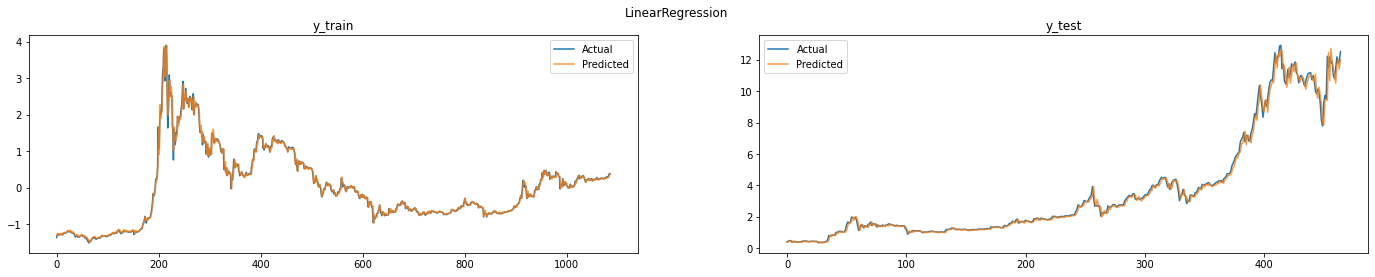

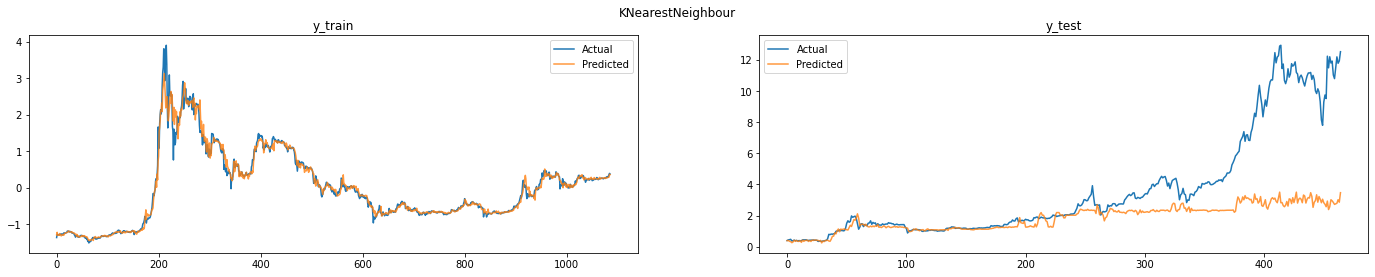

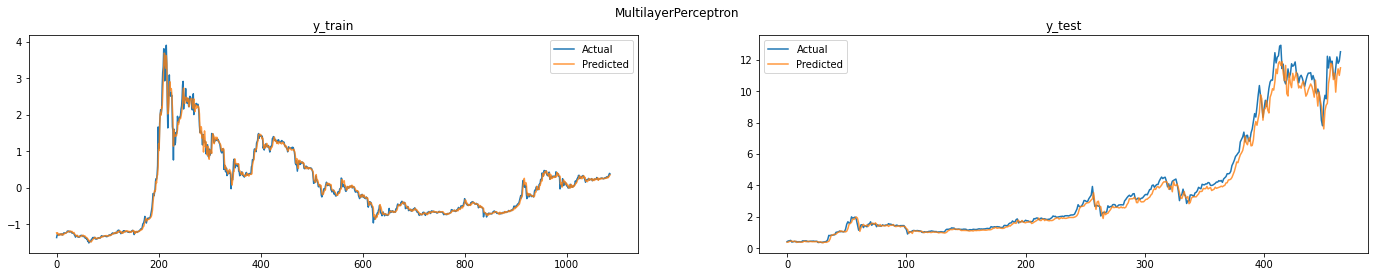

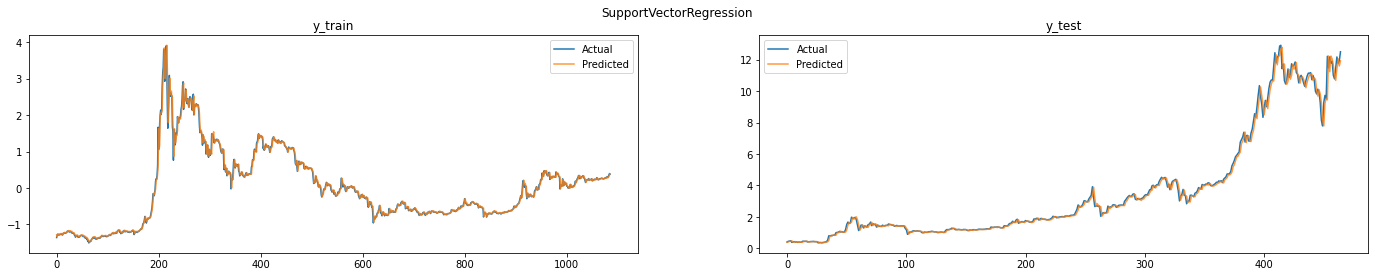

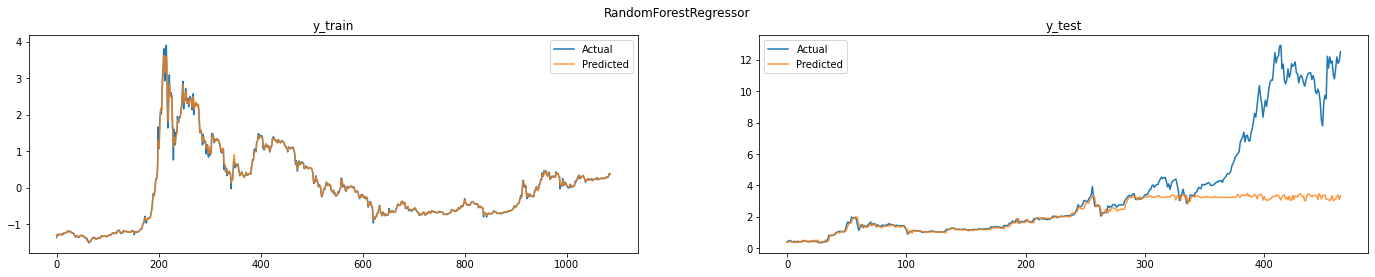

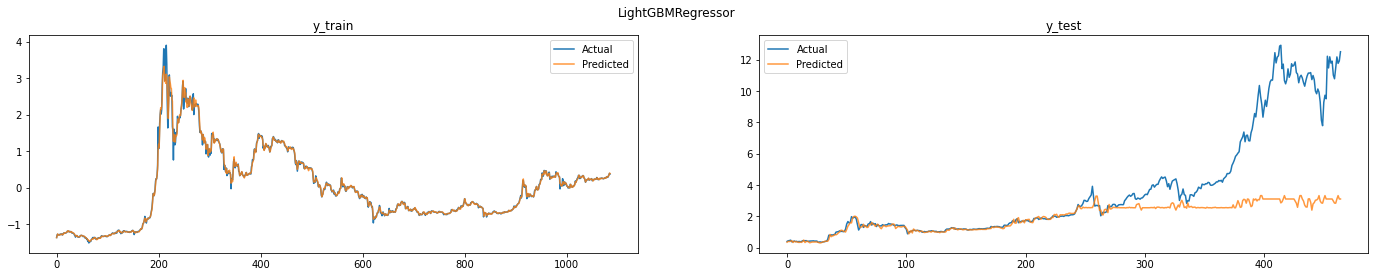

In [ ]:
plot_pred(performance3,y_train_scaled3,y_test_scaled3)

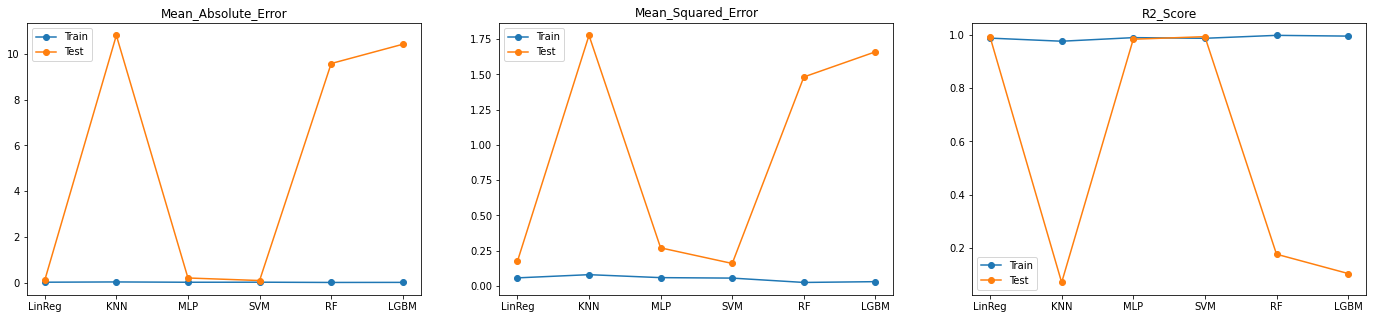

In [ ]:
compare_models(performance3)

## LSTM

In [ ]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss=rmse,optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
X_train_s_1 =X_train_scaled1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test_s_1 = X_test_scaled1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)

In [ ]:
epochs = 100
lstm_model = model.fit(X_train_s_1,y_train_scaled1,validation_data=(X_test_s_1,y_test_scaled1),epochs=epochs,batch_size=32)

Epoch 1/100
34/34 [==============================] - 2s 13ms/step - loss: 0.8260 - mean_absolute_error: 0.6659 - val_loss: 2.8268 - val_mean_absolute_error: 2.7873
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.8119 - mean_absolute_error: 0.6530 - val_loss: 2.7351 - val_mean_absolute_error: 2.6960
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.7956 - mean_absolute_error: 0.6395 - val_loss: 2.6305 - val_mean_absolute_error: 2.5919
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7769 - mean_absolute_error: 0.6249 - val_loss: 2.5204 - val_mean_absolute_error: 2.4822
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 0.7583 - mean_absolute_error: 0.6098 - val_loss: 2.3924 - val_mean_absolute_error: 2.3546
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.7406 - mean_absolute_error: 0.5935 - val_loss: 2.2600 - val_mean_absolute_error: 2.2227
Epoch 7/100
34/34 [==

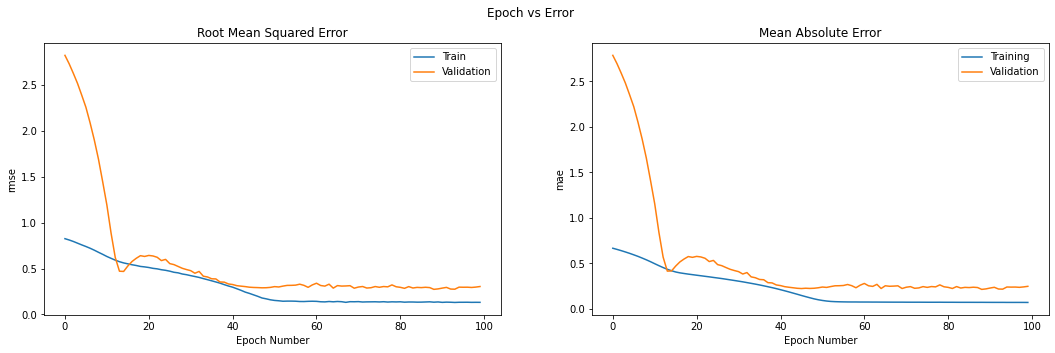

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(18,5))

axs[0].plot(range(epochs), lstm_model.history['loss'], label='Train')
axs[0].plot(range(epochs), lstm_model.history['val_loss'], label='Validation')
axs[0].set_title('Root Mean Squared Error')
axs[0].set_xlabel("Epoch Number")
axs[0].set_ylabel("rmse")
axs[0].legend()

axs[1].plot(range(epochs), lstm_model.history['mean_absolute_error'], label='Training')
axs[1].plot(range(epochs), lstm_model.history['val_mean_absolute_error'], label='Validation')
axs[1].set_title('Mean Absolute Error')
axs[1].set_xlabel("Epoch Number")
axs[1].set_ylabel("mae")
axs[1].legend()

plt.suptitle("Epoch vs Error")
plt.show()


In [ ]:
yptr1 = model.predict(X_train_s_1)
ypts1 = model.predict(X_test_s_1)

In [ ]:
print("Metrics-")
print(f"Train scores: mse: {mse(y_train_scaled1,yptr1)}, mae: {mae(y_train_scaled1,yptr1)}, r2: {r2_s(y_train_scaled1,yptr1)}")
print(f"Test scores: mse: {mse(y_test_scaled1,ypts1)}, mae: {mae(y_test_scaled1,ypts1)}, r2: {r2_s(y_test_scaled1,ypts1)}")

Metrics-
Train scores: mse: 0.02037999612411766, mae: 0.06957399998700596, r2: 0.9796200038758823
Test scores: mse: 0.20933558373151998, mae: 0.24689020286443406, r2: 0.982026905979285


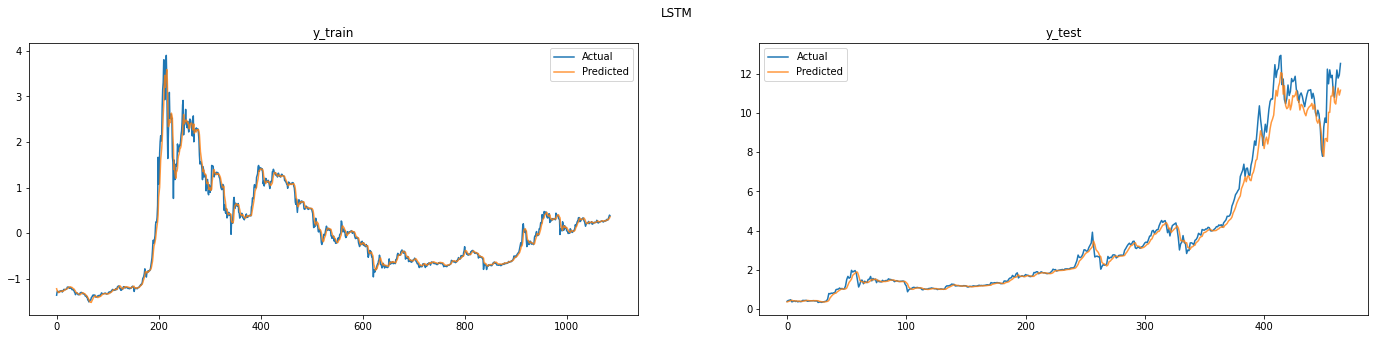

In [ ]:
train_len = len(y_train_scaled1)
test_len = len(y_test_scaled1)

fig, axs = plt.subplots(1, 2,figsize=(24,5))
axs[0].plot(np.arange(train_len),y_train_scaled1,label='Actual')
axs[0].plot(np.arange(train_len),yptr1,label='Predicted',alpha=0.8)
axs[0].set_title(f"y_train")
axs[0].legend()

axs[1].plot(np.arange(test_len),y_test_scaled1,label='Actual')
axs[1].plot(np.arange(test_len),ypts1,label='Predicted',alpha=0.8)
axs[1].set_title(f"y_test")
axs[1].legend()

plt.suptitle("LSTM")
plt.show()